# Dynamics of the Izhikevich Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy.signal import argrelmax

def reset(p, v, u, i):
    """resets the values for v and u at a given index"""
    v[i] = p['c']
    u[i] += p['d']
    
def neuron(p, I, t_max, dt):
    """ returns the membrane potential during a given time approximated with the euler method
    p : dictionary, contains the parameters a, b, c, d
    I : function, I(t) is the current at time t in pA
    t_max : float, time length of the simulation in ms
    dt : float, time step in ms
    """
    # create arrays for t, u and v
    # u0 and v0 were given in the exercise
    t = np.arange(0, t_max, dt)
    u = np.zeros((len(t),1))
    u[0] = 0
    v = np.zeros((len(t),1))
    v[0] = -80
    for i in range(len(t)-1):
        if v[i] >= 30:
            reset(p, v, u, i)
        u[i+1] = u[i] + dt * p['a'] * (p['b'] * v[i] - u[i])
        v[i+1] = v[i] + dt * (0.04 * (v[i])**2 + 5 * v[i] + 140 - u[i] + I(t[i])) 
    return t, v

def neuron_fires(p, I):
    """returns whether the neuron fires with parameters p and current I or not"""
    t, v = neuron(p, I, 300, 0.2)
    return bool(np.max(v) > 0)

def find_threshold(p, acc):
    """finds the threshold needed for the neuron to fire with a given accuracy"""
    # setup arbitray binary search borders
    lower = 0
    upper = 100
    while upper - lower >= acc:
        mid = (lower + upper) / 2
        I = lambda t : mid
        if neuron_fires(p, I):
            upper = mid
        else:
            lower = mid
    return lower

def firing_rate(current, p):
    """computes the firing rate in kHz given an input current I and parameters p"""
    t_max = 250
    dt = 0.1
    I = lambda t : current
    t, v = neuron(p, I, t_max, dt)
    if np.max(v) < 0: # no spikes
        return 0.0 # return float in any case
    else:
        spikes = argrelmax(v)
        if len(spikes[0]) <= 1:
            return 0.0
        else:
            return (len(spikes[0])-1) / (dt * (spikes[0][-1] - spikes[0][0]))

The minimum current needed to activate the neuron is about 13.141 mA.


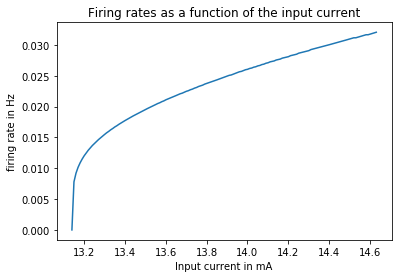

In [3]:
# 1. integrator model
p1 = {
    'a': 0.1,
    'b': 0.05,
    'c': -50,
    'd': 8
}
# determine threshold
I_thresh = find_threshold(p1, 0.001)
print(f'The minimum current needed to activate the neuron is about {np.round(I_thresh, 3)} mA.')

# setup current range and plot firing rates
currents = np.arange(I_thresh, I_thresh + 1.5, 0.01)
firing_rates = np.vectorize(firing_rate)(currents, p1)

plt.plot(currents, firing_rates)
plt.title('Firing rates as a function of the input current')
plt.xlabel('Input current in mA')
plt.ylabel('firing rate in Hz')
plt.show()

$\Longrightarrow$ With these parameters we're modeling a Type 2 neuron.

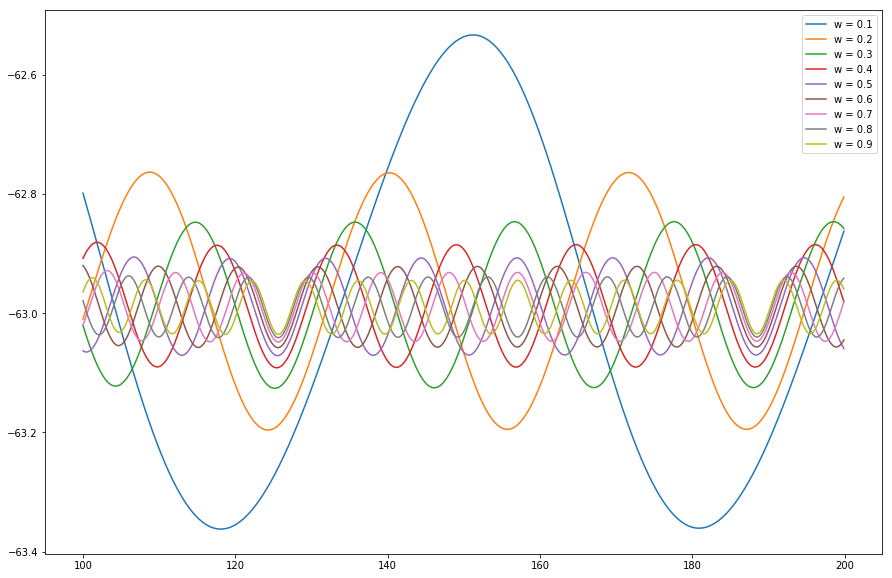

In [5]:
# sinosodial input current

def sinosoidal_current(w, I_thresh):
    return lambda t : I_thresh - 0.05 + 0.04 * np.sin(w*t)

def sinusoidal_neuron(p, omegas, t_max, dt, I_thresh):
    """simulates a neuron with sinusoidal current
    p : paramters for the simulation
    omegas: array with values for w
    t_max, dt : length of simulation and time step
    I_thresh : current threshold to activate neuron
    returns time array and a list of voltage data"""
    simulations = []
    for i in range(len(omegas)):
        w = omegas[i]
        I = sinosoidal_current(w, I_thresh)
        t, v = neuron(p, I, t_max, dt)
        simulations.append(v)
    return np.arange(0, t_max, dt), simulations

t_max = 200
dt = 0.1
omegas = np.arange(0.1, 1, 0.1)
I_thresh = find_threshold(p1, 0.001)

# plot
fig = plt.figure(figsize=(15,10))
t, simulations = sinusoidal_neuron(p1, omegas, t_max, dt, I_thresh)
for i in range(len(omegas)):
    plt.plot(t[1000:], simulations[i][1000:], label=f'w = {np.round(omegas[i], 3)}')
plt.legend()
plt.show()

The voltage can be approximate with $v(t) \approx v_0 + A( \omega ) \sin (\omega t - \varphi)$.


Given the plot we may take an educated guess for the transfer function: $ A( \omega ) = \frac{1}{c \cdot \omega}$, where $c \in \mathbb{R}$.

We now have to match $A(\omega )$ with the amplitude of the resulting voltage $v$.

In [6]:
def amplitude(V):
    """returns the amplitude of a given sinusoidal signal V"""
    return (np.max(V)-np.min(V)) / 2

def A(c):
    return lambda w : 1/(c * w)

def transfer(p, acc, t_max, w_max, dt, dw, I_thresh):
    """approximates c for the transfer function up to a given accuracy
    returns c (float) and the amplitudes(2d array)"""
    # simulate neuron for various values of omega
    omegas = np.arange(0+dw, w_max, dw)
    t, simulations = sinusoidal_neuron(p, omegas, t_max, dt, I_thresh)
    amplitudes = np.zeros((2, len(omegas)))
    for i in range(len(omegas)):
        amplitudes[0][i] = omegas[i]
        amplitudes[1][i] = amplitude(simulations[i][1000:])
    # setup binary search
    lower = 0
    upper = 20
    while upper - lower >= acc:
        mid = A((lower + upper) / 2)
        if np.sum(mid(amplitudes[0]) - amplitudes[1]) > 0: # no need for squares
            lower = (lower + upper) / 2
        else:
            upper = (lower + upper) / 2
    return lower, amplitudes

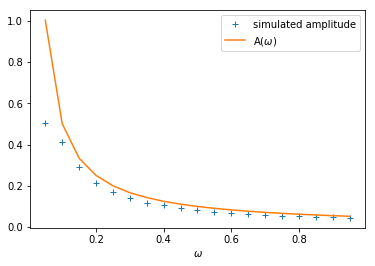

In [8]:
# plot transfer function against the simulated amplitudes
I_thresh = find_threshold(p1, 0.001)
t_max = 1000
w_max = 1
dt = 0.1
dw = 0.05
omegas = np.arange(0 + dw, w_max, dw)
c, amps = transfer(p1, 0 + dw, t_max, w_max, dt, dw, I_thresh)
plt.plot(amps[0], amps[1], '+', label='simulated amplitude')    
plt.plot(omegas, A(c)(omegas), label='A($\omega$)')
plt.xlabel('$\omega$')
plt.legend()
plt.show()

However, a sinusoidal current may elicit action potentials as well. This is just not visible because our step is too large. With a smaller step size it becomes clear that the oscillations of the current and the voltage will eventually line up and elicit spiking.

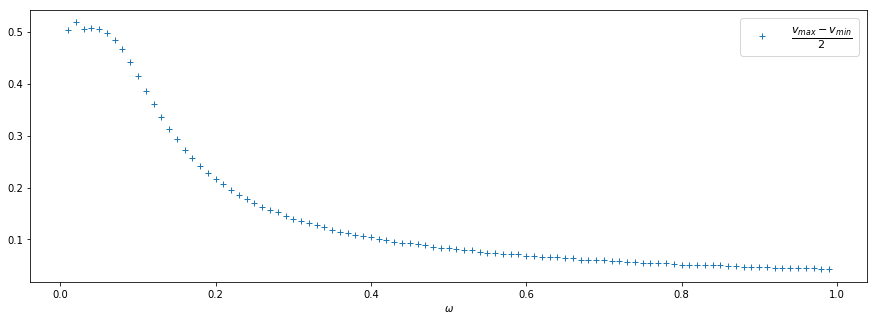

In [9]:
t_max = 500
w_max = 1
dt = 0.1
dw = 0.01
omegas = np.arange(0 + dw, w_max, dw)
c, amps = transfer(p1, 0.0001, t_max, w_max, dt, dw, I_thresh)
fig = plt.figure(figsize=(15,5))
plt.plot(amps[0], amps[1], '+', label='$ \\frac{ v_{max} - v_{min} }{2}$')    
plt.xlabel('$\omega$')
plt.legend(prop={'size': 16})
plt.show()

The minimum current needed to activate the neuron is about 0.14038 mA.


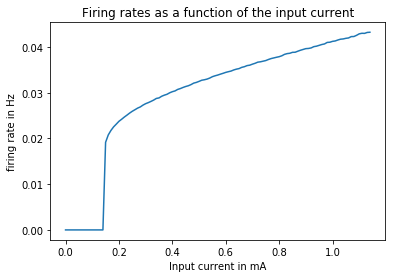

In [15]:
# 2. resonator model
p2 = {
    'a': 0.1,
    'b': 0.26,
    'c': -65,
    'd': 2
}

# calculate and plot threshold
# determine threshold
I_thresh = find_threshold(p2, 0.001)
print(f'The minimum current needed to activate the neuron is about {np.round(I_thresh, 5)} mA.')

# setup current range and plot firing rates
t_max = 400
dt  = 0.01
currents = np.arange(0, I_thresh + 1, 0.01)
firing_rates = np.vectorize(firing_rate)(currents, p2)

plt.plot(currents, firing_rates)
plt.title('Firing rates as a function of the input current')
plt.xlabel('Input current in mA')
plt.ylabel('firing rate in Hz')
plt.show()

$\Longrightarrow$ With these parameters we're modeling a Type 2 neuron.

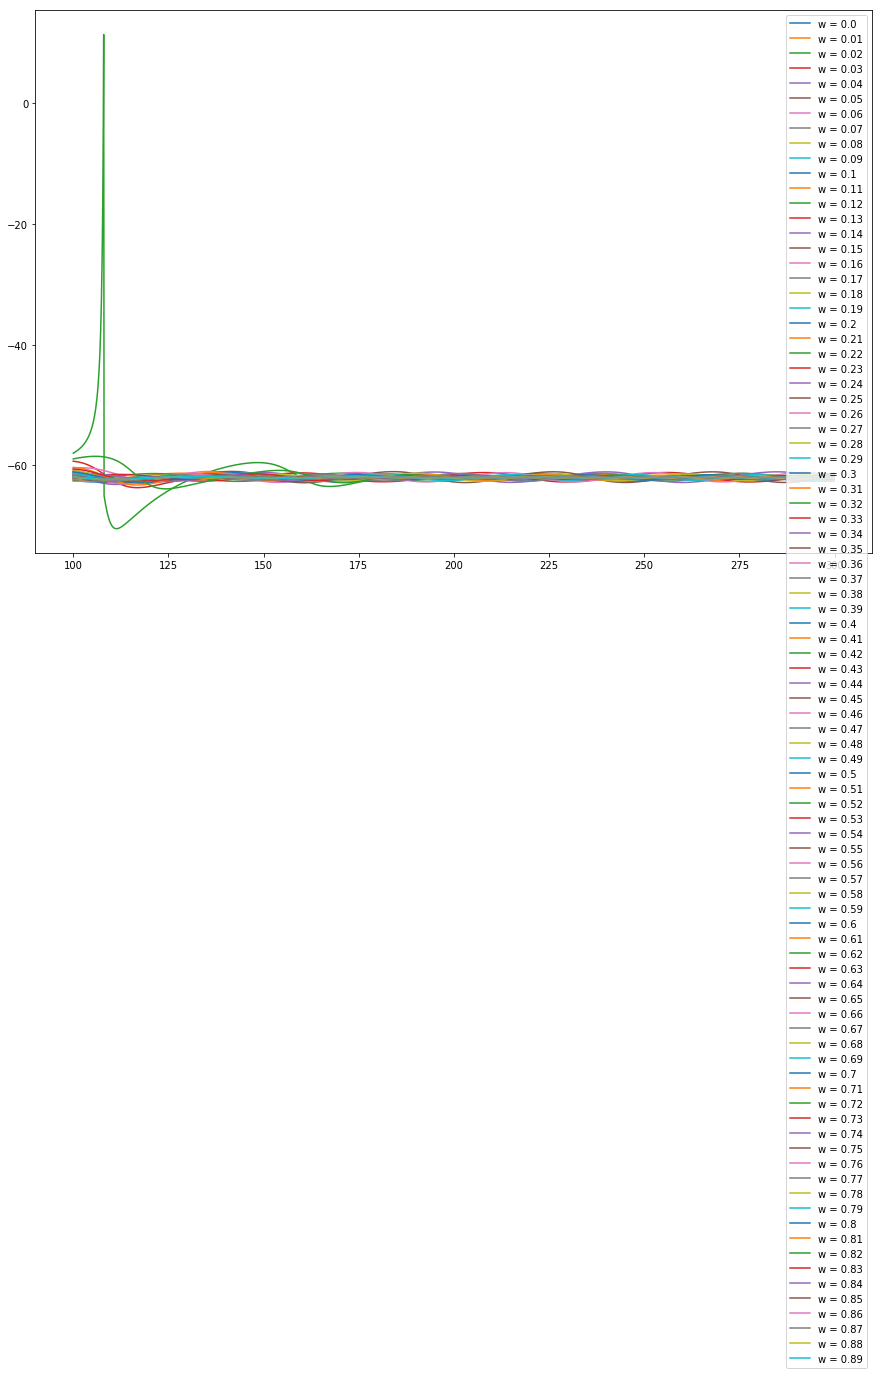

In [41]:
# plot transfer function against the simulated amplitudes
I_thresh2 = find_threshold(p2, 0.0001)
t_max = 300
w_min = 0.0
w_max = 0.9
dt = 0.1
dw = 0.01
omegas = np.arange(w_min, w_max, dw)
# plot
fig = plt.figure(figsize=(15,10))
t, simulations = sinusoidal_neuron(p2, omegas, t_max, dt, I_thresh2+0.03) # + 0.03 should not be there!
for i in range(len(omegas)):
    plt.plot(t[1000:], simulations[i][1000:], label=f'w = {np.round(omegas[i], 3)}')
plt.legend()
plt.show()